In [1]:
!pip install scanpy

                                              0.0/2.0 MB ? eta -:--:--
     ---------                                0.5/2.0 MB 15.4 MB/s eta 0:00:01
     ---------------------------              1.4/2.0 MB 18.0 MB/s eta 0:00:01
     -------------------------------------    1.9/2.0 MB 15.0 MB/s eta 0:00:01
     ---------------------------------------  2.0/2.0 MB 14.3 MB/s eta 0:00:01
     ---------------------------------------- 2.0/2.0 MB 11.8 MB/s eta 0:00:00
                                              0.0/118.9 kB ? eta -:--:--
     -------------------------------------- 118.9/118.9 kB 6.8 MB/s eta 0:00:00
                                              0.0/90.8 kB ? eta -:--:--
     ---------------------------------------- 90.8/90.8 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                

In [2]:
import scanpy as sc 

In [3]:
adata = sc.read_csv('GSM5226574_C51ctr_raw_counts.csv').T
adata

AnnData object with n_obs × n_vars = 6099 × 34546

In [4]:
adata.X.shape

(6099, 34546)

# Doublet removal - optional but preferred

In [5]:
!pip install scvi-tools

                                              0.0/351.5 kB ? eta -:--:--
     ------------------------------------  348.2/351.5 kB 10.9 MB/s eta 0:00:01
     -------------------------------------- 351.5/351.5 kB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                                              0.0/1.9 MB ? eta -:--:--
     -------------                            0.7/1.9 MB 20.2 MB/s eta 0:00:01
     ----------------------------             1.4/1.9 MB 17.3 MB/s eta 0:00:01
     ---------------------------------------  1.9/1.9 MB 15.2 MB/s eta 0:00:01
     ---------------------------------------- 1.9/1.9 MB 13.5 MB/s eta 0:00:00
                                              0.0/77.9 kB ? eta -:--:--
     ---------------------------------------- 77.9/77.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
                        

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.13.0 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.8.0 which is incompatible.


In [10]:
pip install --upgrade typing-extensions


In [25]:
adata

AnnData object with n_obs × n_vars = 6099 × 19896
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [26]:
sc.pp.filter_genes(adata, min_cells = 10)

In [ ]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

In [ ]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

In [ ]:
df = solo.predict()
df['prediction'] = solo.predict(soft = False)

df.index = df.index.map(lambda x: x[:-2])

df

In [ ]:
df.groupby('prediction').count()

In [ ]:
df['dif'] = df.doublet - df.singlet
df

In [ ]:
import seaborn as sns

In [ ]:
sns.displot(df[df.prediction == 'doublet'], x = 'dif')

In [ ]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

In [26]:
adata = sc.read_csv('raw_counts/GSM5226574_C51ctr_raw_counts.csv').T

In [29]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [30]:
adata.obs

,doublet
TAGGTACCATGGCCAC-1_1,True
ATTCACTGTAACAGGC-1_1,True
TAACTTCCAACCACGC-1_1,True
TTGGGTACACGACAAG-1_1,True
AGGCCACAGAGTCACG-1_1,True
...,...
CGCCATTGTTTGCCGG-1_1,False
CACTGGGGTCTACGTA-1_1,False
CATACTTGTAGAGGAA-1_1,False
TTTGGTTTCCACGGAC-1_1,False


In [31]:
adata = adata[~adata.obs.doublet]

In [32]:
adata

View of AnnData object with n_obs × n_vars = 5639 × 34546
    obs: 'doublet'

# Preprocessing

In [11]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')

In [12]:
adata.var

,n_cells,mt
AL627309.5,33,False
LINC01409,274,False
LINC01128,81,False
LINC00115,15,False
SAMD11,16,False
...,...,...
MAFIP,34,False
AC011043.1,11,False
AL354822.1,133,False
AL592183.1,1003,False


In [13]:
import pandas as pd

In [14]:
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"

In [15]:
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
ribo_genes

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L
...,...
83,RPS9
84,RPSA
85,RSL24D1
86,RSL24D1P11


In [16]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [17]:
adata.obs

""
TAGGTACCATGGCCAC-1_1
ATTCACTGTAACAGGC-1_1
TAACTTCCAACCACGC-1_1
TTGGGTACACGACAAG-1_1
AGGCCACAGAGTCACG-1_1
...
CGCCATTGTTTGCCGG-1_1
CACTGGGGTCTACGTA-1_1
CATACTTGTAGAGGAA-1_1
TTTGGTTTCCACGGAC-1_1


In [18]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [19]:
adata.var.sort_values('n_cells_by_counts')

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RNF17,10,False,False,10,0.001640,99.836039,10.0
AL512625.1,10,False,False,10,0.001640,99.836039,10.0
LINC00092,10,False,False,10,0.001640,99.836039,10.0
AL138895.1,10,False,False,10,0.001640,99.836039,10.0
AL356481.3,10,False,False,10,0.001640,99.836039,10.0
...,...,...,...,...,...,...,...
AKAP13,4458,False,False,4458,3.054271,26.906050,18628.0
NEAT1,4546,False,False,4546,5.314150,25.463191,32411.0
MBNL1,4554,False,False,4554,2.877029,25.332022,17547.0
ZBTB20,4699,False,False,4699,2.601082,22.954583,15864.0


In [20]:
sc.pp.filter_genes(adata, min_cells=3)

In [21]:
adata.var.sort_values('n_cells_by_counts')

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
RNF17,10,False,False,10,0.001640,99.836039,10.0
AL512625.1,10,False,False,10,0.001640,99.836039,10.0
LINC00092,10,False,False,10,0.001640,99.836039,10.0
AL138895.1,10,False,False,10,0.001640,99.836039,10.0
AL356481.3,10,False,False,10,0.001640,99.836039,10.0
...,...,...,...,...,...,...,...
AKAP13,4458,False,False,4458,3.054271,26.906050,18628.0
NEAT1,4546,False,False,4546,5.314150,25.463191,32411.0
MBNL1,4554,False,False,4554,2.877029,25.332022,17547.0
ZBTB20,4699,False,False,4699,2.601082,22.954583,15864.0


In [22]:
adata.obs.sort_values('n_genes_by_counts')

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
TAGGGTTTCTGGCTGG-1_1,271,414.0,1.0,0.241546,1.0,0.241546
TGACAGTTCTAAACGC-1_1,273,409.0,0.0,0.000000,0.0,0.000000
CGTGCTTCAAAGGGCT-1_1,276,431.0,41.0,9.512761,0.0,0.000000
CTCTGGTCACGACGAA-1_1,282,404.0,0.0,0.000000,0.0,0.000000
GGCTGTGTCTAACGCA-1_1,283,593.0,45.0,7.588532,12.0,2.023609
...,...,...,...,...,...,...
TAACTTCCAACCACGC-1_1,5097,15573.0,221.0,1.419123,209.0,1.342066
CACTGAAGTCGAAGCA-1_1,5395,12628.0,355.0,2.811213,82.0,0.649351
AGGCCACAGAGTCACG-1_1,5476,13147.0,417.0,3.171826,82.0,0.623716
ATTCACTGTAACAGGC-1_1,6581,18913.0,404.0,2.136097,115.0,0.608047


In [23]:
#sc.pp.filter_cells(adata, min_genes=200)

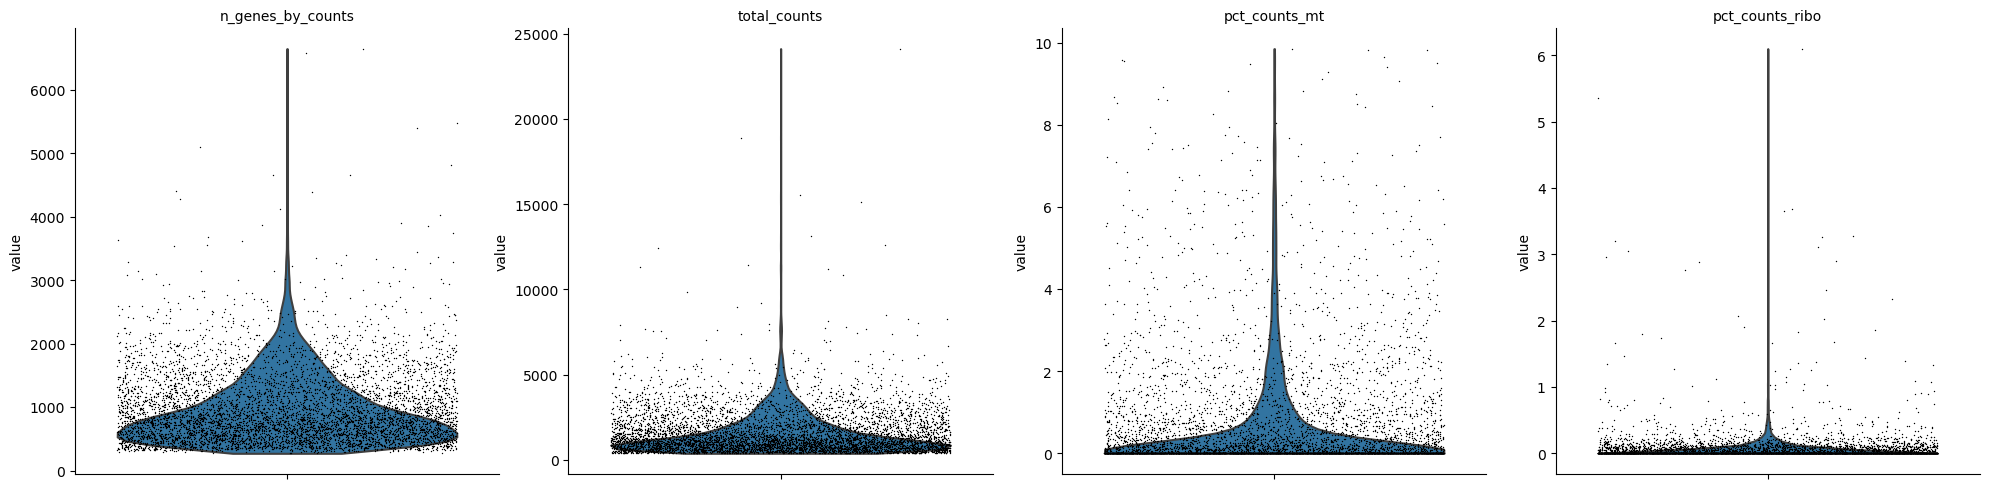

In [24]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], 
             jitter=0.4, multi_panel=True)

In [27]:
import numpy as np

In [28]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)
#upper_lim = 3000

In [29]:
upper_lim

2459.24

In [30]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]

In [31]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
CGTTCTGGTACTAGCT-1_1,2423,6035.0,6.0,0.099420,1.0,0.016570
CTGGCAGGTTCGGTAT-1_1,2431,5885.0,307.0,5.216652,5.0,0.084962
ACACCAACACAACGCC-1_1,2443,5489.0,0.0,0.000000,3.0,0.054655
CCTCAACCATACAGGG-1_1,2266,5424.0,38.0,0.700590,0.0,0.000000
ACAAAGATCCACAGGC-1_1,2302,5496.0,1.0,0.018195,1.0,0.018195
...,...,...,...,...,...,...
CGCCATTGTTTGCCGG-1_1,354,409.0,3.0,0.733496,0.0,0.000000
CACTGGGGTCTACGTA-1_1,346,403.0,0.0,0.000000,0.0,0.000000
CATACTTGTAGAGGAA-1_1,359,409.0,2.0,0.488998,0.0,0.000000
TTTGGTTTCCACGGAC-1_1,299,405.0,0.0,0.000000,2.0,0.493827


In [32]:
adata = adata[adata.obs.pct_counts_mt < 20]

In [33]:
adata = adata[adata.obs.pct_counts_ribo < 2]

In [34]:
adata

View of AnnData object with n_obs × n_vars = 5960 × 19896
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Normalization

In [35]:
adata.X.sum(axis = 1)

array([6035., 5885., 5489., ...,  409.,  405.,  409.], dtype=float32)

In [36]:
sc.pp.normalize_total(adata, target_sum=1e4) #normalize every cell to 10,000 UMI

C:\Users\tusha\anaconda3\Lib\site-packages\scanpy\preprocessing\_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [37]:
adata.X.sum(axis = 1)

array([ 9999.999, 10000.   , 10000.   , ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

In [38]:
sc.pp.log1p(adata) #change to log counts

In [39]:
adata.X.sum(axis = 1)

array([3149.9697, 3211.5012, 3411.0479, ..., 1188.8802, 1022.7511,
       1160.4647], dtype=float32)

In [40]:
adata.raw = adata

# Clustering

In [41]:
sc.pp.highly_variable_genes(adata, n_top_genes = 2000)

In [42]:
adata.var

,n_cells,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.5,33,False,False,33,0.005411,99.458928,33.0,False,0.028925,2.257216,-0.378348
LINC01409,274,False,False,274,0.048697,95.507460,297.0,False,0.271186,2.289900,-0.255400
LINC01128,81,False,False,81,0.013773,98.671913,84.0,False,0.108685,2.476471,0.446422
LINC00115,15,False,False,15,0.002459,99.754058,15.0,False,0.012416,1.998004,-1.353426
SAMD11,16,False,False,16,0.002951,99.737662,18.0,False,0.025776,2.487115,0.486464
...,...,...,...,...,...,...,...,...,...,...,...
MAFIP,34,False,False,34,0.005575,99.442532,34.0,False,0.038546,2.478839,0.455330
AC011043.1,11,False,False,11,0.001968,99.819643,12.0,False,0.012436,2.356142,-0.006218
AL354822.1,133,False,False,133,0.022627,97.819315,138.0,False,0.154419,2.379528,0.081751
AL592183.1,1003,False,False,1003,0.198721,83.554681,1212.0,False,0.876707,2.473240,-0.404264


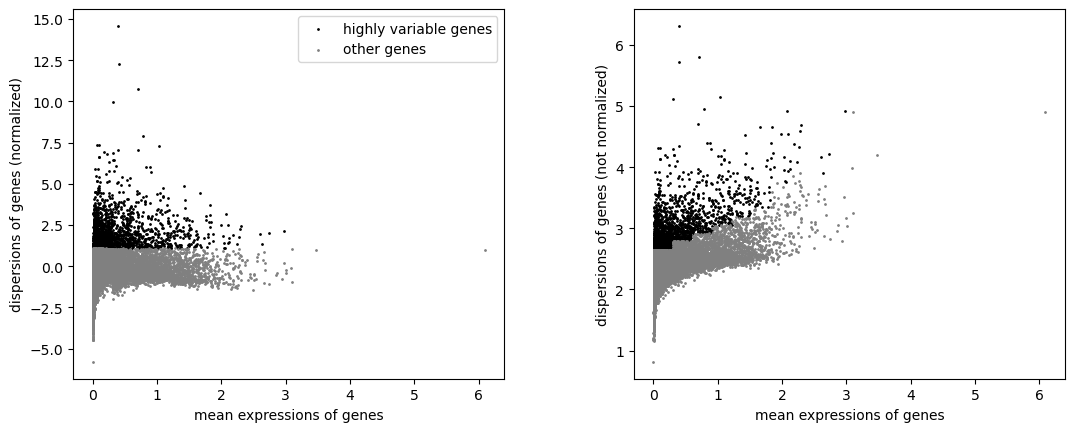

In [43]:
sc.pl.highly_variable_genes(adata)

# Find markers/ label cell types

In [62]:
sc.tl.leiden(adata, resolution = 1)

In [63]:
sc.tl.rank_genes_groups(adata, 'leiden')

C:\Users\tusha\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\tusha\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:398: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\tusha\anaconda3\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:401: PerformanceWarning: DataFrame is highly fragmented.  This is usually t

In [64]:
#sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [65]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]
markers

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,NCKAP5,152.955551,7.718144,0.000000,0.000000
1,0,EMP2,123.223740,6.979469,0.000000,0.000000
2,0,NEDD4L,84.427689,4.988759,0.000000,0.000000
3,0,LMO7,81.879494,5.753130,0.000000,0.000000
4,0,AC027288.3,80.441559,6.660552,0.000000,0.000000
...,...,...,...,...,...,...
517706,26,ZFAND3,2.309646,1.113971,0.032874,0.047644
517707,26,EIF5B,2.308521,1.948867,0.033007,0.047827
517708,26,ASH1L,2.300705,1.073966,0.033458,0.048466
517709,26,CYBA,2.291860,2.655036,0.034156,0.049460


In [68]:
cell_type = {"0":"Macrophage",
"1":"Fibroblast",
"2":"CD4+ T-cell",
"3":"AT2",
"4":"AT1",
"5":"CD8+ T-cell",
"6":"Endothelial cell",
"7":"Plasma cell",
"8":"Macrophage",
"9":"AT2",
"10":"Fibroblast",
"11":"Fibroblast",
"12":"Macrophage",
"13":"Macrophage",
"14":"Airway epithelial",
"15":"Airway epithelial",
"16":"Monocyte",
"17":"Airway epithelial",
"18":"B-cell",
"19":"Aerocyte",
"20":"Airway epithelial",
"21":"Smooth muscle cell",
"22":"Cycling T/NK",
"23":"Neuronal cell",
"24":"Denditic cell",
"25":"Pericyte",
"26":"Fibroblast",
"27":"Erythroid-like",
"28":"Macrophage"
}


In [69]:
adata.obs['cell type'] = adata.obs.leiden.map(cell_type)

C:\Users\tusha\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


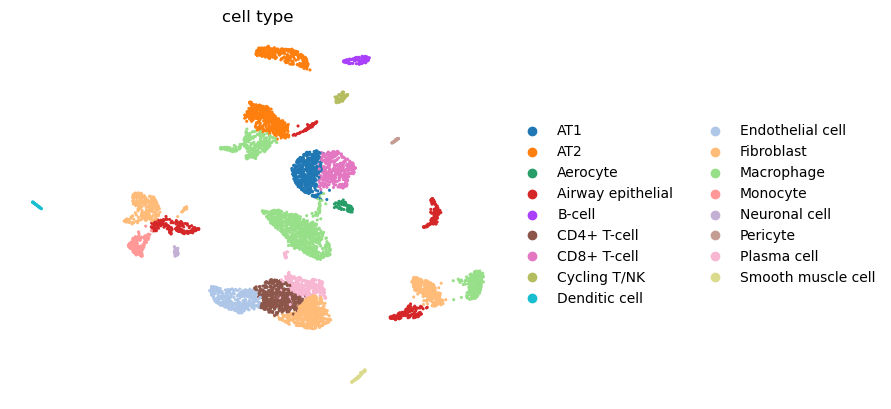

In [70]:
sc.pl.umap(adata, color = ['cell type'], frameon = False)

## Score gene signature

In [92]:
#for thumbnail

In [93]:
from matplotlib.pyplot import rc_context


In [94]:
adata

AnnData object with n_obs × n_vars = 5960 × 2000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'leiden', 'cell type'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups', 'cell type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

C:\Users\tusha\anaconda3\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


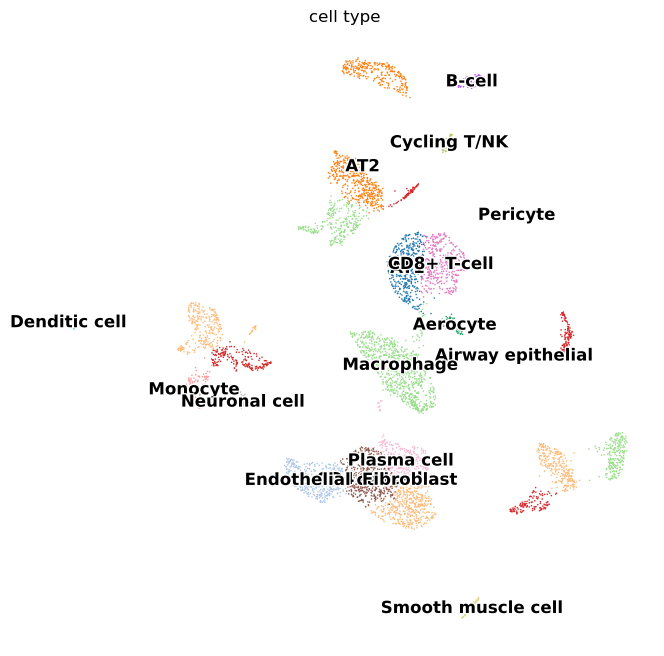

In [95]:
with rc_context({'figure.figsize': (8,8)}):
    sc.pl.umap(adata, color = ['cell type'], frameon = False, s = 5, legend_loc = 'on data',
              legend_fontsize=12, legend_fontoutline=2)